# Table of Contents

* [Project Libraries](#project_libraries)
* [Creating Spark Instance](#creating_spark_instance)
* [Importing Data](#importing_data)
* [EDA](#eda)
    * [Origin and Destination Aiport Counts](#orig_dest_airport_counts)
    * [Correlation Matrix](#correlation_matrix)
    * [Pairplot](#pairplot)
    * [Summary Table](#summary_table)
    * [Null Counts](#null_counts)
* [Stop Spark Session](#stop_spark_session)


# Libraries <a class="anchor" id="project_libraries"></a>

In [16]:
import pandas as pd
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import seaborn as sns
import matplotlib.pyplot as plt

import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, IntegerType, StringType
from pyspark.sql.functions import col,isnan, when, count
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler

from IPython.display import Image

# Creating Spark Instance <a class="anchor" id="creating_spark_instance"></a>

In [2]:
conf = pyspark.SparkConf().setAll([
        ('spark.master',   'local[*]'),
        ('spark.app.name', 'PySpark Plane Data')])

# Schema for original data set
schema = StructType([StructField("YEAR", StringType(), False),
                        StructField("MONTH", StringType(), False),
                        StructField("DAY", StringType(), False),
                        StructField("DAY_OF_WEEK", StringType(), False),
                        StructField("AIRLINE", StringType(), False),
                        StructField("FLIGHT_NUMBER", StringType(), True),
                        StructField("TAIL_NUMBER", StringType(), True),
                        StructField("ORIGIN_AIRPORT", StringType(), False),
                        StructField("DESTINATION_AIRPORT", StringType(), False),
                        StructField("SCHEDULED_DEPARTURE", IntegerType(), False),
                        StructField("DEPARTURE_TIME", IntegerType(), True),
                        StructField("DEPARTURE_DELAY", IntegerType(), True),
                        StructField("TAXI_OUT", IntegerType(), True),
                        StructField("WHEELS_OFF", IntegerType(), True),
                        StructField("SCHEDULED_TIME", IntegerType(), True),
                        StructField("ELAPSED_TIME", IntegerType(), True),
                        StructField("AIR_TIME", IntegerType(), True),
                        StructField("DISTANCE", IntegerType(), True),
                        StructField("WHEELS_ON", IntegerType(), True),
                        StructField("TAXI_IN", IntegerType(), True),
                        StructField("SCHEDULED_ARRIVAL", IntegerType(), True),
                        StructField("ARRIVAL_TIME", IntegerType(), True),
                        StructField("ARRIVAL_DELAY", IntegerType(), True),
                        StructField("DIVERTED", StringType(), True),
                        StructField("CANCELLED", StringType(), True),
                        StructField("CANCELLATION_REASON", StringType(), True),
                        StructField("AIR_SYSTEM_DELAY", IntegerType(), True),
                        StructField("SECURITY_DELAY", IntegerType(), True),
                        StructField("AIRLINE_DELAY", IntegerType(), True),
                        StructField("LATE_AIRCRAFT_DELAY", IntegerType(), True),
                        StructField("WEATHER_DELAY", StringType(), True),
                    ])

# Importing Data <a class="anchor" id="importing_data"></a>

In [3]:
# Creating Spark session
spark = SparkSession.builder.config(conf=conf).getOrCreate()
df = spark.read.csv("flight-delays/flights.csv",
                            header=True,
                            schema = schema)

22/05/03 11:17:05 WARN Utils: Your hostname, Carloss-MacBook-Air.local resolves to a loopback address: 127.0.0.1; using 192.168.0.225 instead (on interface en0)
22/05/03 11:17:05 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/05/03 11:17:09 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:
df.show(2)

22/05/03 11:17:34 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+----+-----+---+-----------+-------+-------------+-----------+--------------+-------------------+-------------------+--------------+---------------+--------+----------+--------------+------------+--------+--------+---------+-------+-----------------+------------+-------------+--------+---------+-------------------+----------------+--------------+-------------+-------------------+-------------+
|YEAR|MONTH|DAY|DAY_OF_WEEK|AIRLINE|FLIGHT_NUMBER|TAIL_NUMBER|ORIGIN_AIRPORT|DESTINATION_AIRPORT|SCHEDULED_DEPARTURE|DEPARTURE_TIME|DEPARTURE_DELAY|TAXI_OUT|WHEELS_OFF|SCHEDULED_TIME|ELAPSED_TIME|AIR_TIME|DISTANCE|WHEELS_ON|TAXI_IN|SCHEDULED_ARRIVAL|ARRIVAL_TIME|ARRIVAL_DELAY|DIVERTED|CANCELLED|CANCELLATION_REASON|AIR_SYSTEM_DELAY|SECURITY_DELAY|AIRLINE_DELAY|LATE_AIRCRAFT_DELAY|WEATHER_DELAY|
+----+-----+---+-----------+-------+-------------+-----------+--------------+-------------------+-------------------+--------------+---------------+--------+----------+--------------+------------+--------+-

In [7]:
# Data Shape
print('There are {} rows and {} columns in the data'.format(df.count(), len(df.columns)))

There are 5819079 rows and 31 columns in the data


# EDA <a class="anchor" id="eda"></a>

## Origin and Destination Aiport Counts <a class="anchor" id="orig_dest_airport_counts"></a>

In [9]:
# Top 5 airports with planes outbound
origin_airport_count = df.groupBy('ORIGIN_AIRPORT').count().orderBy('count', ascending=False)

# Top 5 airports with planes inbound
destination_airport_count = df.groupBy('DESTINATION_AIRPORT').count().orderBy('count', ascending=False)

In [13]:
fig = make_subplots(rows=2, 
                    cols=1,
                    subplot_titles=("Origin Airport Counts", "Destination Airport Counts"))

fig.add_trace(go.Bar(x = origin_airport_count.toPandas()['ORIGIN_AIRPORT'].astype(str), 
                        y = origin_airport_count.toPandas()['count']),
                row=1, col=1)

fig.add_trace(go.Bar(x = destination_airport_count.toPandas()['DESTINATION_AIRPORT'].astype(str), 
                        y = destination_airport_count.toPandas()['count']),
                row=2, col=1)

fig.update_xaxes(title_text = "Origin Aiport", row=1, col=1)
fig.update_xaxes(title_text = "Destination Aiport", row=2, col=1)

fig.update_yaxes(title_text = "Count", row=1, col=1)
fig.update_yaxes(title_text = "Count", row=2, col=1)

fig.update_layout(height=900, width = 900,showlegend=False)
fig.write_image("EDA_Static_Images/Origin_Destination_Airport_Count.png")

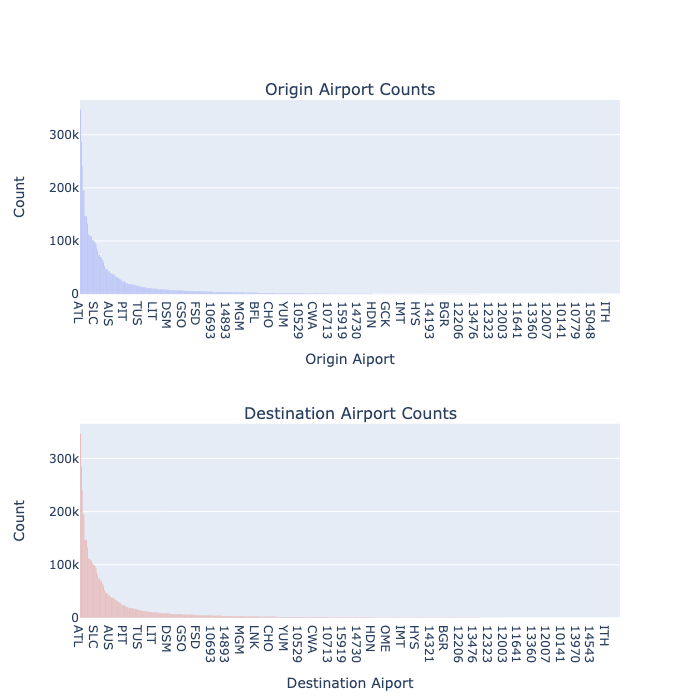

In [14]:
Image(filename="EDA_Static_Images/Origin_Destination_Airport_Count.png")

## Correlation Matrix <a class="anchor" id="correlation_matrix"></a>

In [17]:
integer_cols = [f.name for f in df.schema.fields if isinstance(f.dataType, IntegerType)]
integer_df = df[[integer_cols]]
integer_df_drop_na = integer_df.na.drop("any")

vector_col = "corr_features"
assembler = VectorAssembler(inputCols = integer_df_drop_na.columns, 
                            outputCol = vector_col)
df_vector = assembler.transform(integer_df_drop_na).select(vector_col)

matrix = Correlation.corr(df_vector, vector_col)
matrix_array = matrix.collect()[0]["pearson({})".format(vector_col)].values
matrix_array = matrix_array.reshape((len(integer_cols), len(integer_cols)))

22/05/03 11:25:10 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
22/05/03 11:25:10 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS
/Users/CarlosMonsivais/Desktop/dse230_plane/pyspark_230_env/lib/python3.8/site-packages/pyspark/sql/context.py:125: FutureWarning:

Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.



In [19]:
fig = go.Figure(data=go.Heatmap(z = matrix_array,
                                x = integer_cols,
                                y = integer_cols,
                                text = matrix_array,
                                hoverongaps = False))
fig.update_layout(title={'text': "Correlation Plot",
                            'x':0.5,
                            'xanchor': 'center',
                            'yanchor': 'top'},
                    yaxis_nticks=len(integer_cols),
                    xaxis_nticks=len(integer_cols))
fig.write_image("EDA_Static_Images/Correlation_Plot.png")

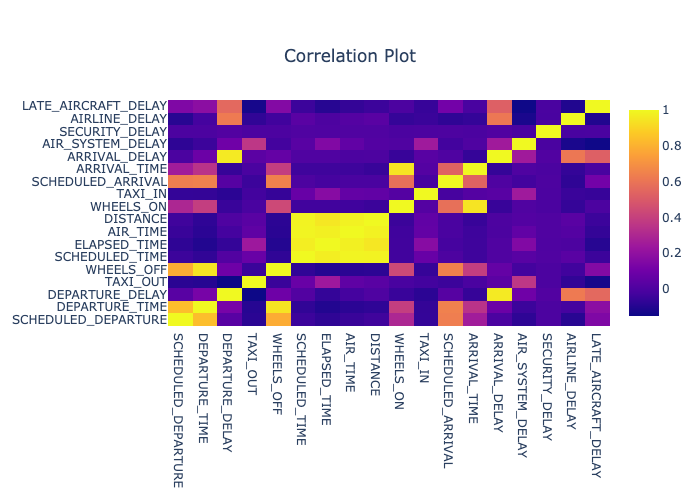

In [20]:
Image(filename="EDA_Static_Images/Correlation_Plot.png")

## Pairplot <a class="anchor" id="pairplot"></a>

In [21]:
pairplot = df.limit(2000)

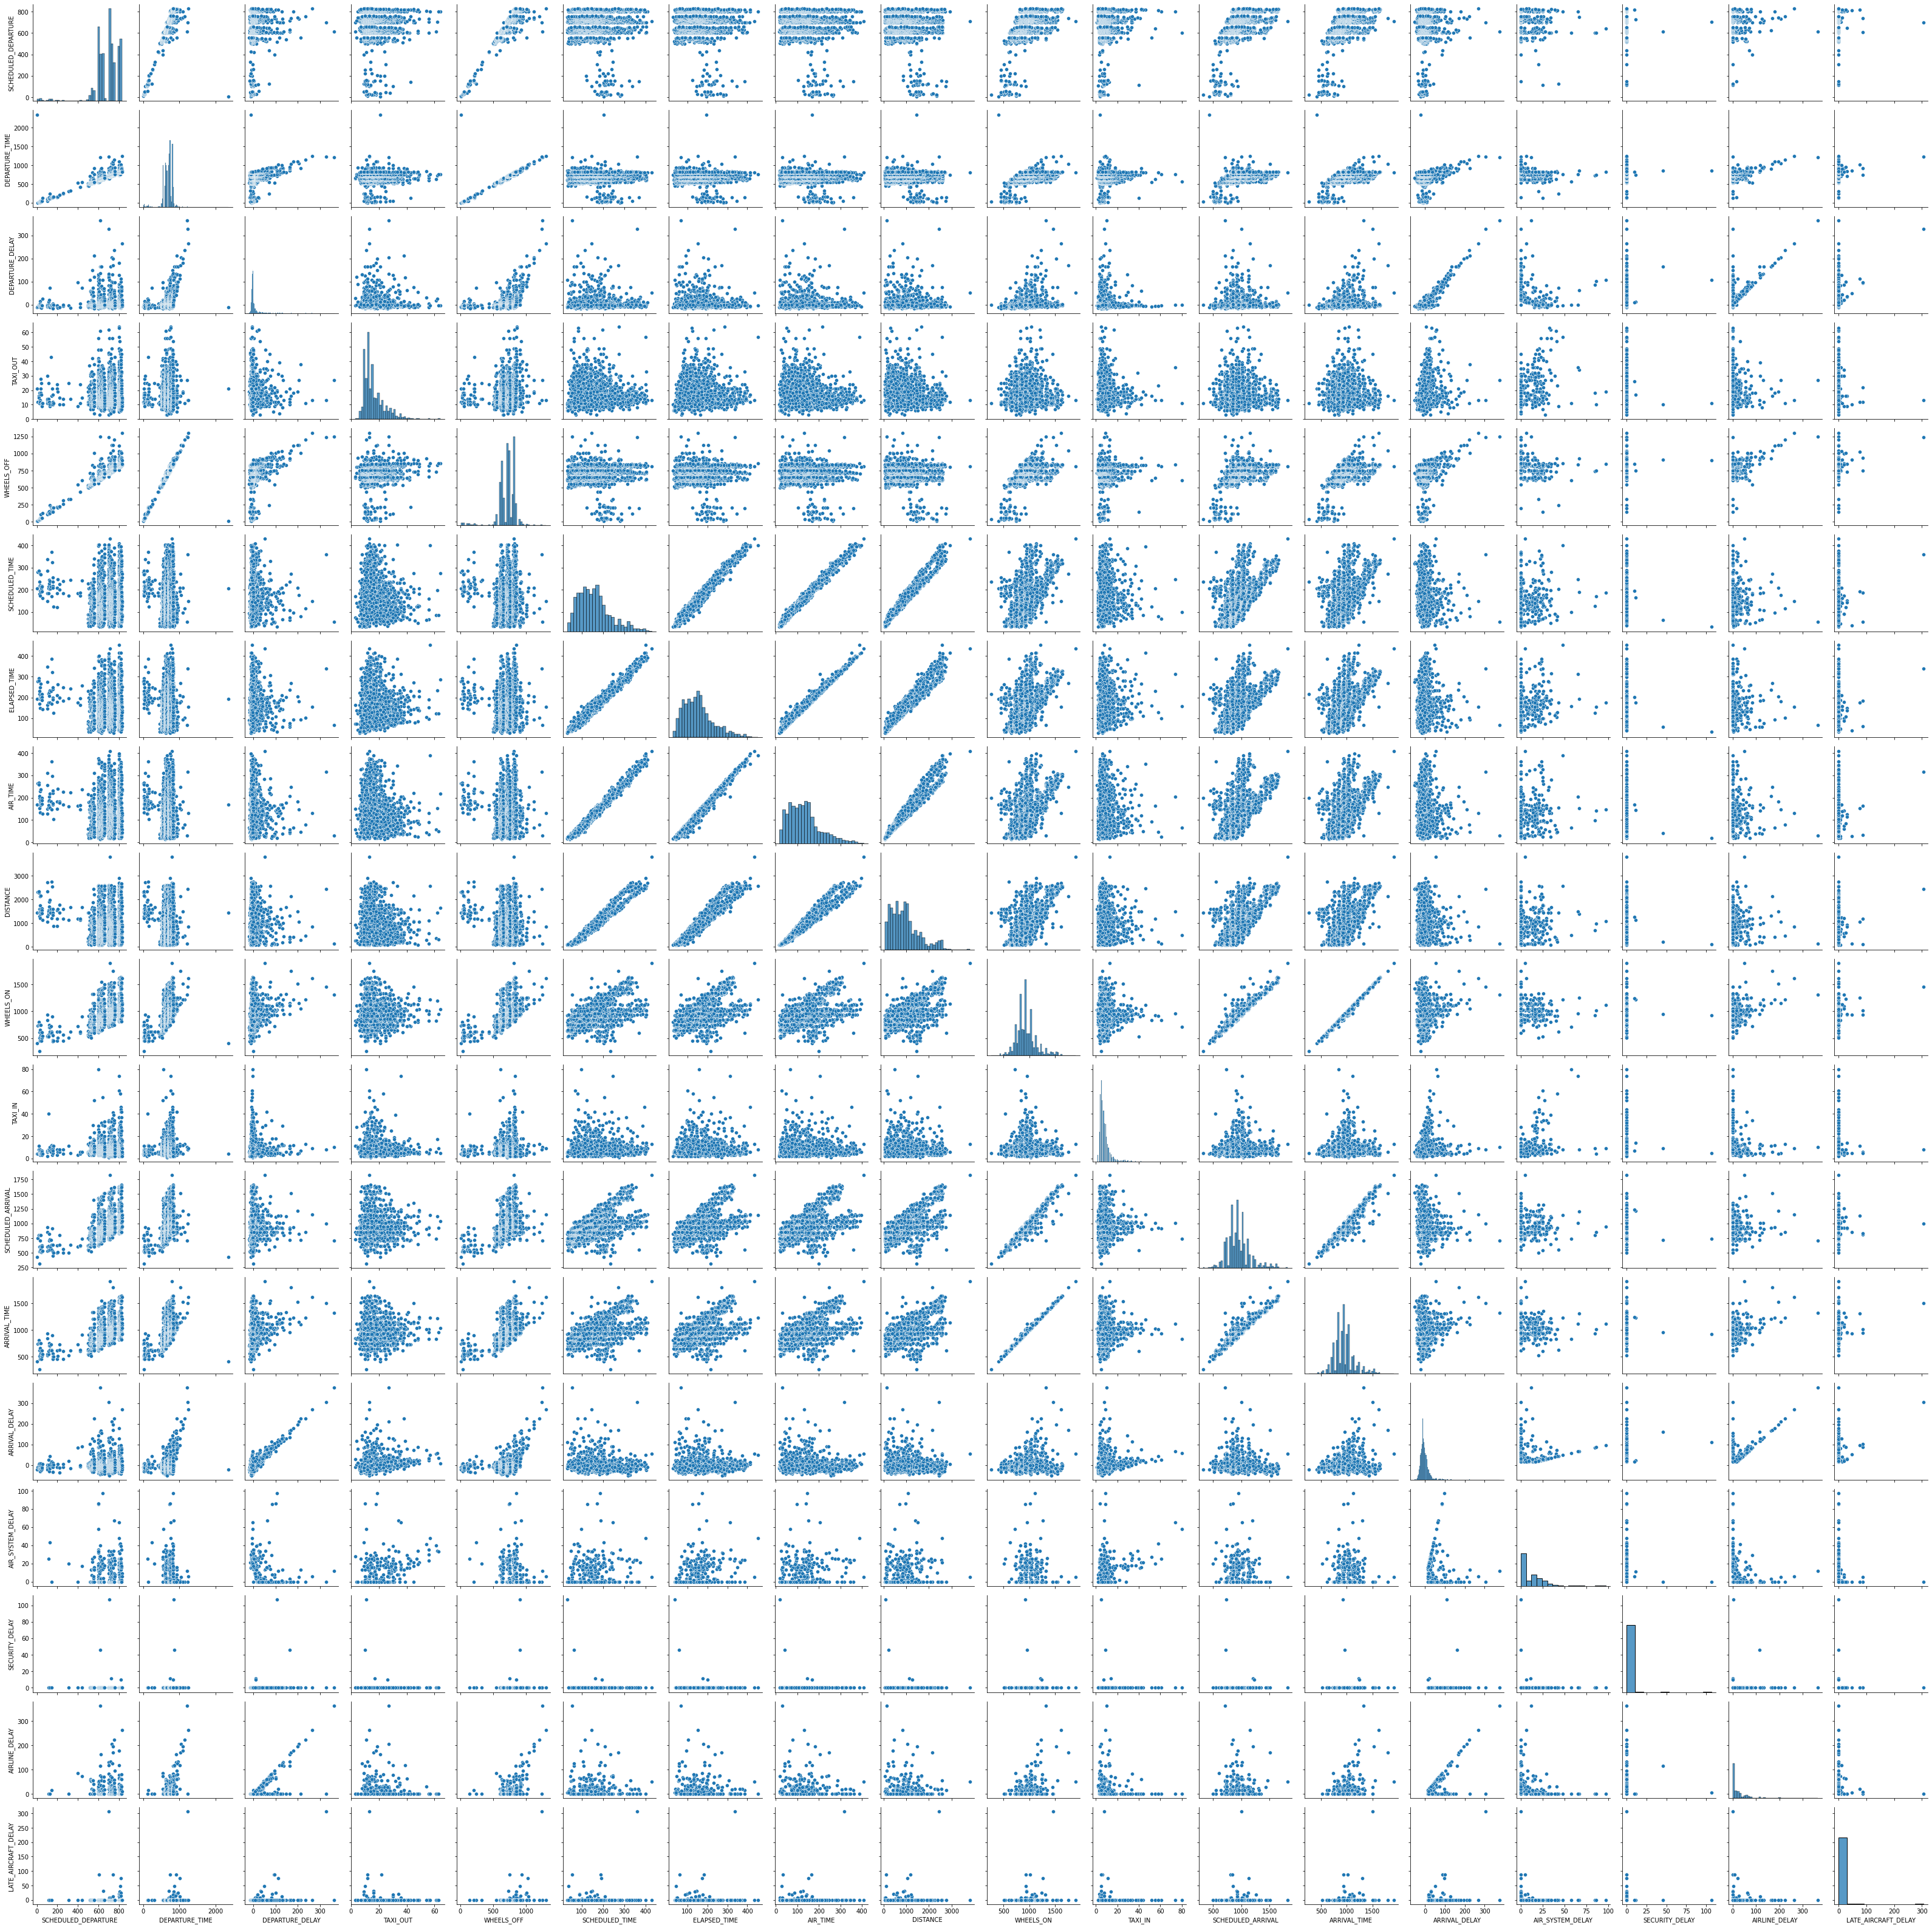

In [23]:
fig = sns.PairGrid(pairplot.toPandas())
fig.map_diag(sns.histplot)
fig.map_offdiag(sns.scatterplot)
plt.savefig('EDA_Static_Images/Pairplot.png')

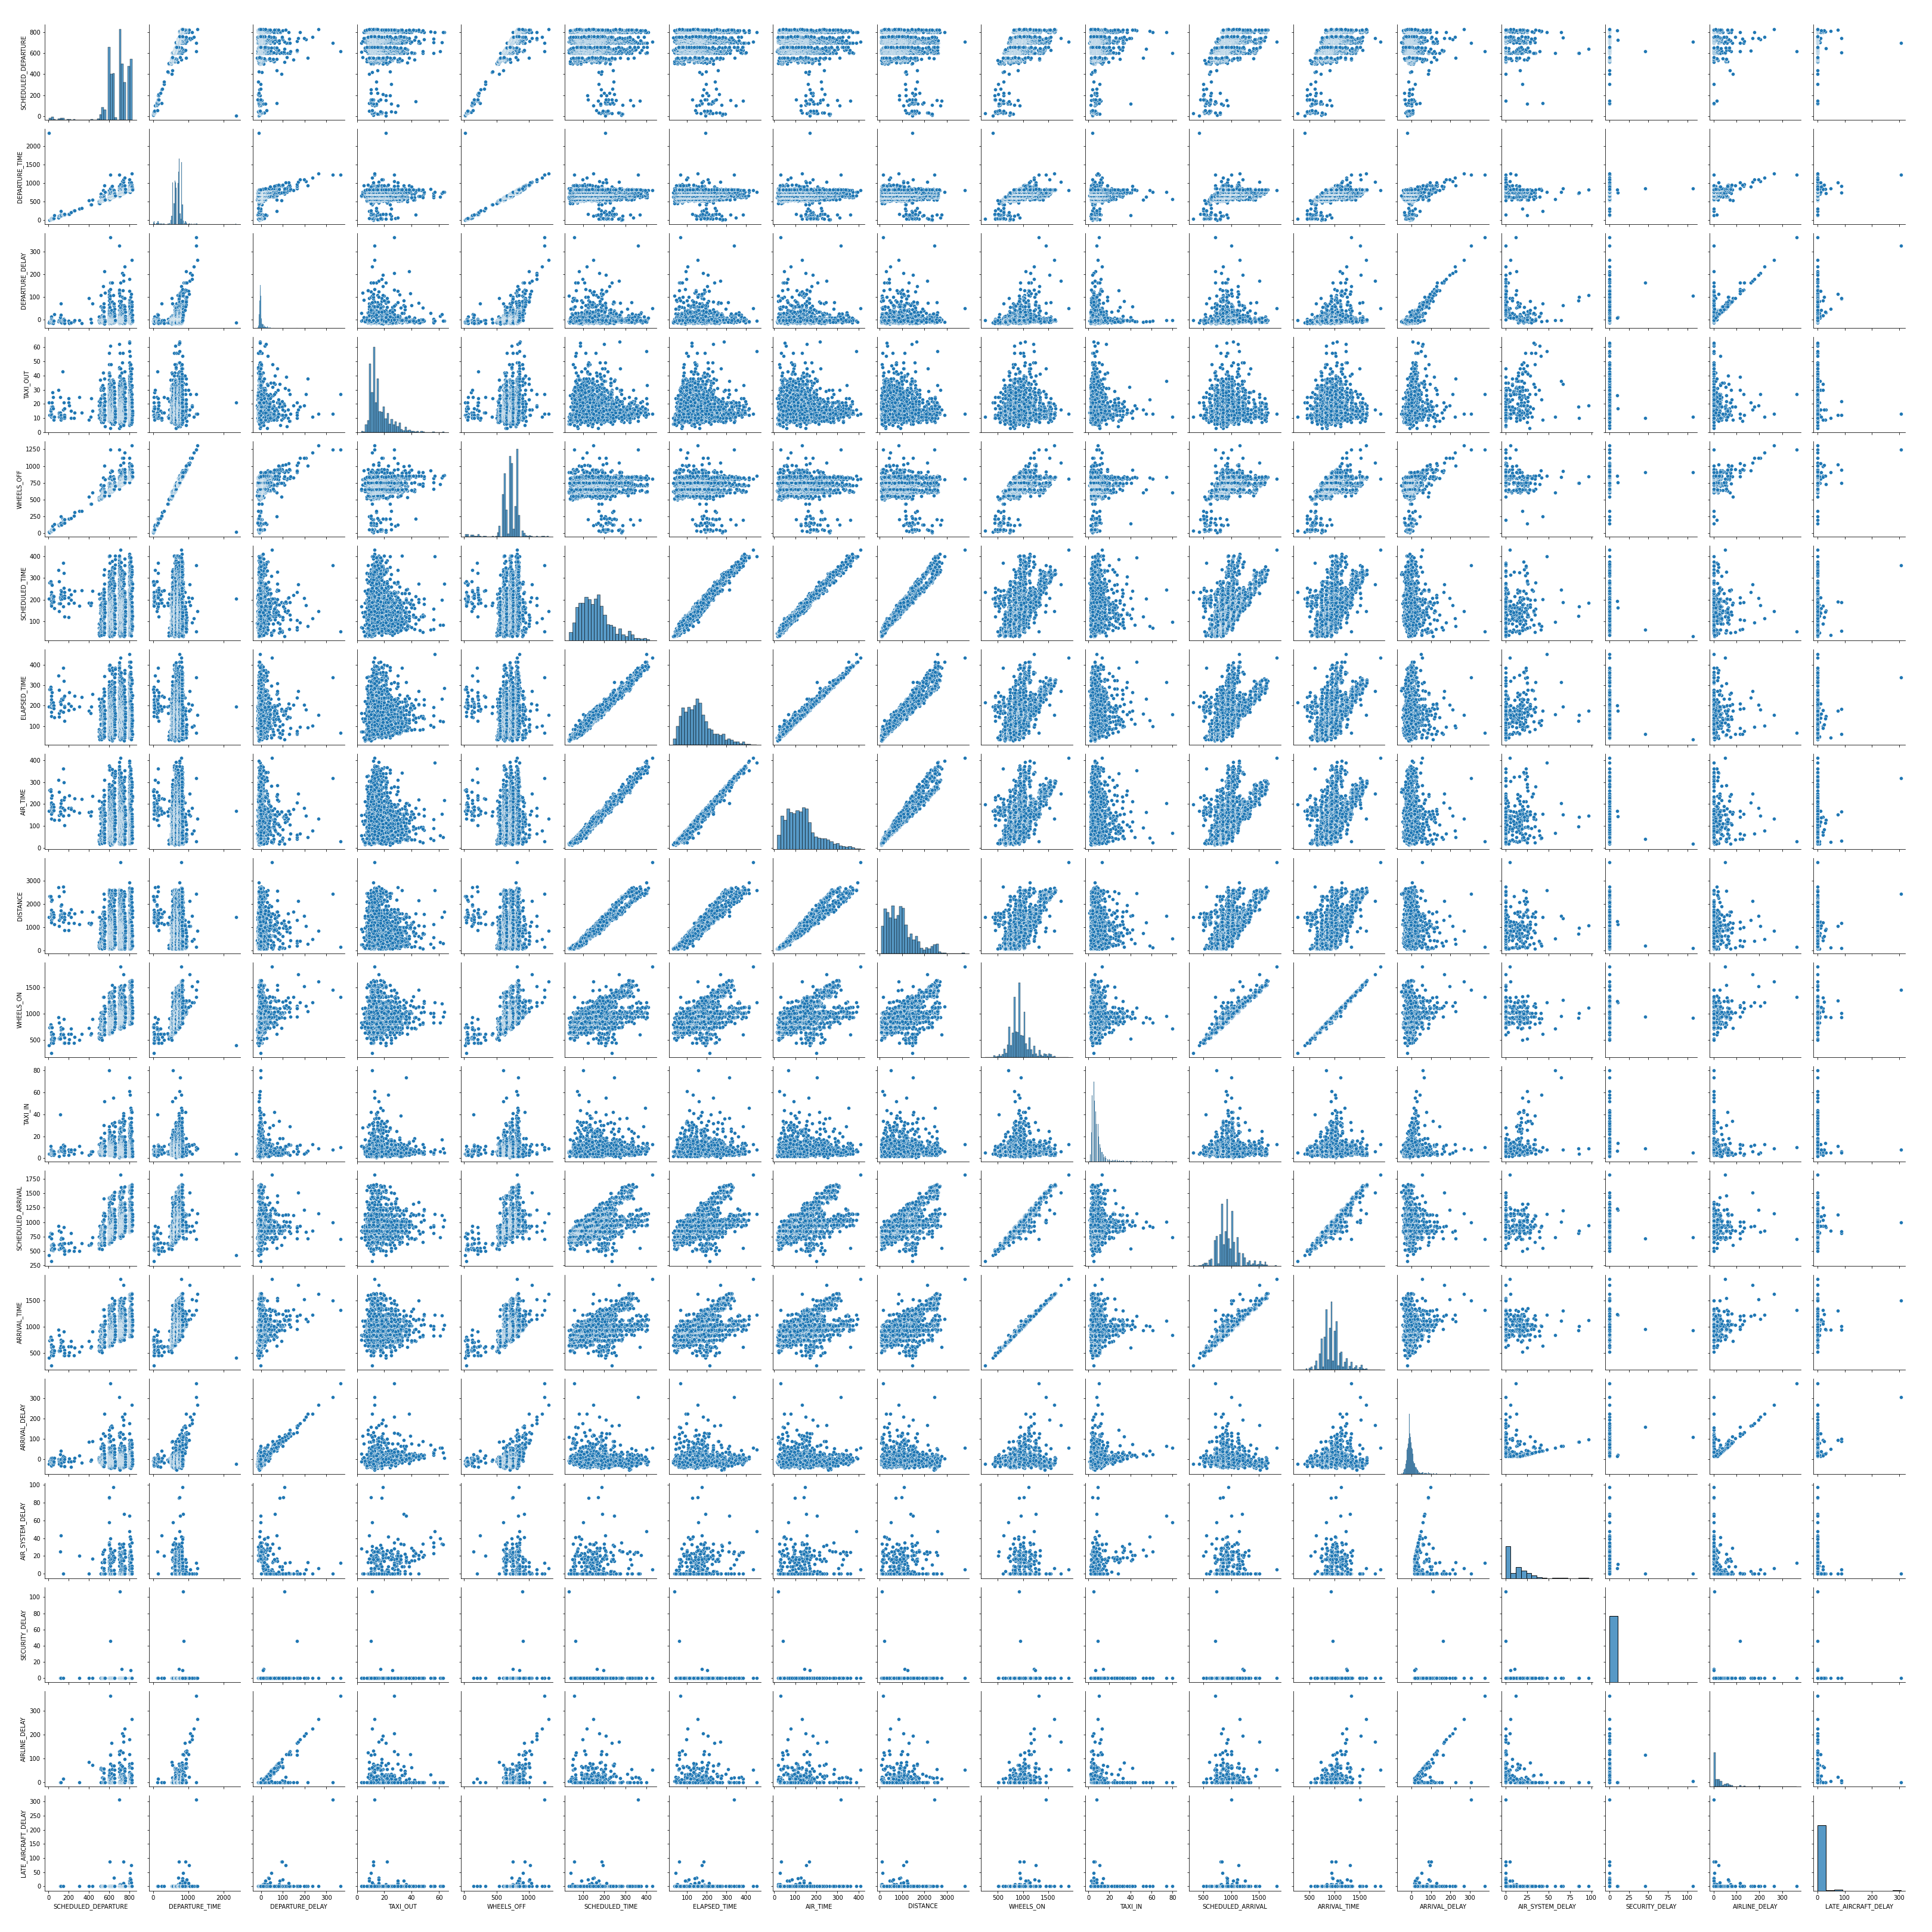

In [24]:
Image(filename="EDA_Static_Images/Pairplot.png")

## Summary Table <a class="anchor" id="summary_table"></a>

In [ ]:
summary_table = df.summary()
pandas_summary = summary_table.toPandas()

In [ ]:
summary_pandas_df = pandas_summary.T
summary_pandas_df.rename(columns = summary_pandas_df.iloc[0], inplace = True)
summary_pandas_df_table = summary_pandas_df.iloc[1:]
summary_pandas_df_table.reset_index(inplace = True, drop = False)
summary_pandas_df_table.rename(columns={summary_pandas_df_table.columns[0]: "Columns" }, inplace = True)
summary_pandas_df_table['mean'] = summary_pandas_df_table['mean'].astype(float)
summary_pandas_df_table['mean'] = summary_pandas_df_table['mean'].round(2)
summary_pandas_df_table['stddev'] = summary_pandas_df_table['stddev'].astype(float)
summary_pandas_df_table['stddev'] = summary_pandas_df_table['stddev'].round(2)

In [ ]:
fig = go.Figure(data=[go.Table(header=dict(values=list(self.summary_pandas_df_table.columns)),
                cells=dict(values=[self.summary_pandas_df_table['Columns'],
                                    self.summary_pandas_df_table['count'],
                                    self.summary_pandas_df_table['mean'],
                                    self.summary_pandas_df_table['stddev'],
                                    self.summary_pandas_df_table['min'],
                                    self.summary_pandas_df_table['25%'],
                                    self.summary_pandas_df_table['50%'],
                                    self.summary_pandas_df_table['75%'],
                                    self.summary_pandas_df_table['max']],
                            font_size=9       
                                    ))])
fig.update_layout(width=1500,
                  height=900)
fig.write_image("EDA_Static_Images/Summary_Table.png")
# fig.write_html("EDA_HTML_Images/Summary_Table.html")
fig.show()

## Null Counts <a class="anchor" id="null_counts"></a>

In [ ]:
null_counts_df = df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns])
null_counts_pandas = null_counts_df.toPandas()

In [ ]:
fig = go.Figure(data=[go.Bar(x = list(null_counts_pandas.columns), 
                                y = null_counts_pandas.values.tolist()[0],
                                text = null_counts_pandas.values.tolist()[0],
                                textposition = 'auto')])
fig.update_layout(title={'text': "Null Value Count",
                        'x':0.5,
                        'xanchor': 'center',
                        'yanchor': 'top'},
                xaxis_title = "Column Names",
                yaxis_title = "Null Counts")                            

fig.write_image("EDA_Static_Images/Null_Values.png")
# fig.write_html("EDA_HTML_Images/Null_Values.html")
fig.show()

# Stop Spark Session <a class="anchor" id="stop_spark_session"></a>

In [ ]:
spark.stop()

# Rendered EDA Images

In [ ]:
Image(filename="EDA_Static_Images/Summary_Table.png")

In [ ]:
Image(filename="EDA_Static_Images/Null_Values.png")